## 載入數據和查看

In [160]:
path = "data/hour_noheader.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print first
print num_data

[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
17379


In [161]:
records.cache()

PythonRDD[2202] at RDD at PythonRDD.scala:48

In [162]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

print "Mapping of first categorical feature column: %s" % get_mapping(records, 2)

Mapping of first categorical feature column: {u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [163]:
mappings = [get_mapping(records, i) for i in range(2, 10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len

print "Feature vector length for categorical features: %d" % cat_len
print "Feature vector length for numerical features: %d" % num_len
print "Total feature vector length: %d" % total_len

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


In [164]:
map(len, mappings)

[4, 2, 12, 24, 2, 7, 2, 4]

## 為線性模型創建特徵向量

In [165]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    return float(record[-1])

data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [166]:
first_point = data.first()
print "Raw data: " + str(first[2:])
print "Label: " + str(first_point.label)
print "Linear Model feature vector: " + str(first_point.features)
print "Linear Model feature vector length: " + str(len(first_point.features))

Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
Label: 16.0
Linear Model feature vector: [1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


## 為決策樹創建特徵向量

In [167]:
def extract_features_dt(record):
    #return np.array(map(float, reocrd[2:14]))
    return np.array([float(field) for field in record[2:14]])

data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))

In [168]:
first_point_dt = data_dt.first()
print "Decision Tree feature vector: " + str(first_point_dt.features)
print "Decision Tree feature vector length: " + str(len(first_point_dt.features))

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length: 12


In [169]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree

#help(LinearRegressionWithSGD.train)
#help(DecisionTree.trainRegressor)

In [170]:
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept=False)
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))
print "Linear Model predictions: " + str(true_vs_predicted.take(5))

Linear Model predictions: [(16.0, 117.89250386724844), (40.0, 116.22496123192109), (32.0, 116.02369145779232), (13.0, 115.67088016754431), (1.0, 115.56315650834316)]


In [171]:
dt_model = DecisionTree.trainRegressor(data_dt, {})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p: p.label)
true_vs_predicted_dt = actual.zip(preds)
print "Decision Tree predictions: " + str(true_vs_predicted_dt.take(5))
print "Decision Tree depth: " + str(dt_model.depth())
print "Decision Tree number of nodes: " + str(dt_model.numNodes())

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


In [172]:
def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(actual, pred):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [173]:
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())

print "Linear Model - Mean Squared Error: %2.4f" % mse
print "Linear Model - Mean Absoluate Error: %2.4f" % mae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absoluate Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


In [174]:
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())

print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt
print "Decision Tree - Mean Absoluate ErrorL %2.4f" % mae_dt
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt

Decision Tree - Mean Squared Error: 11560.7978
Decision Tree - Mean Absoluate ErrorL 71.0969
Decision Tree - Root Mean Squared Log Error: 0.6259


In [175]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


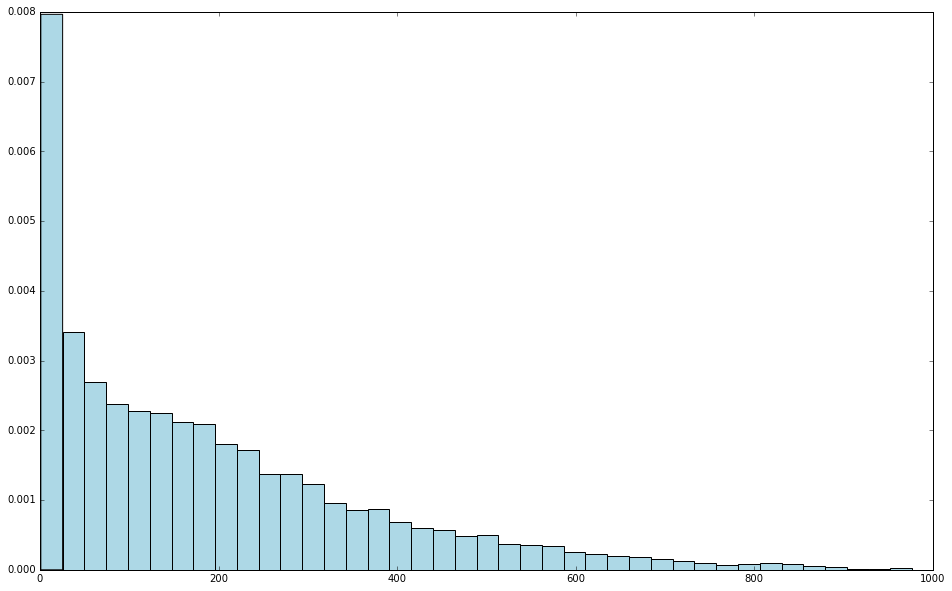

In [176]:
targets = records.map(lambda r: float(r[-1])).collect()
hist(targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

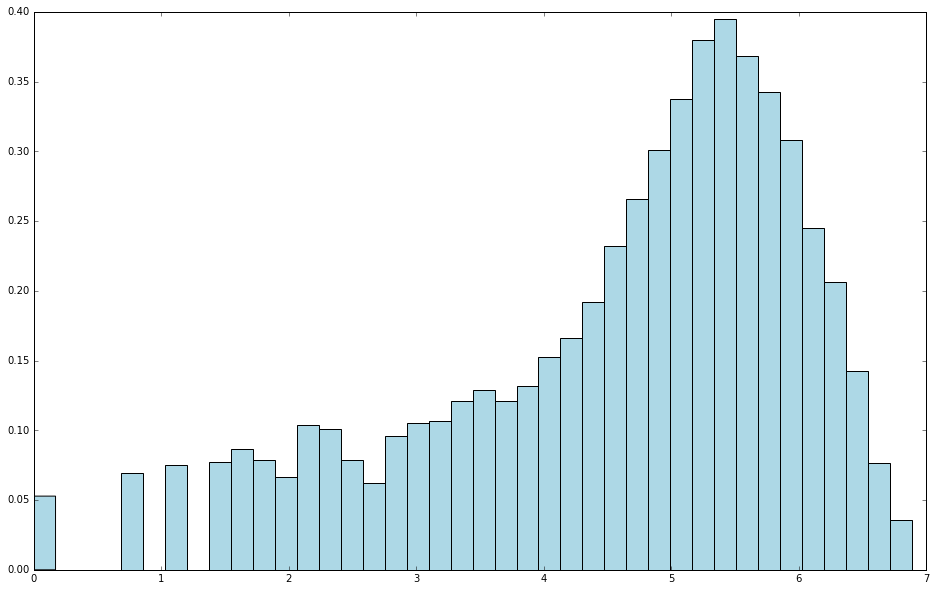

In [177]:
log_features = records.map(lambda r: np.log(float(r[-1]))).collect()
hist(log_features, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

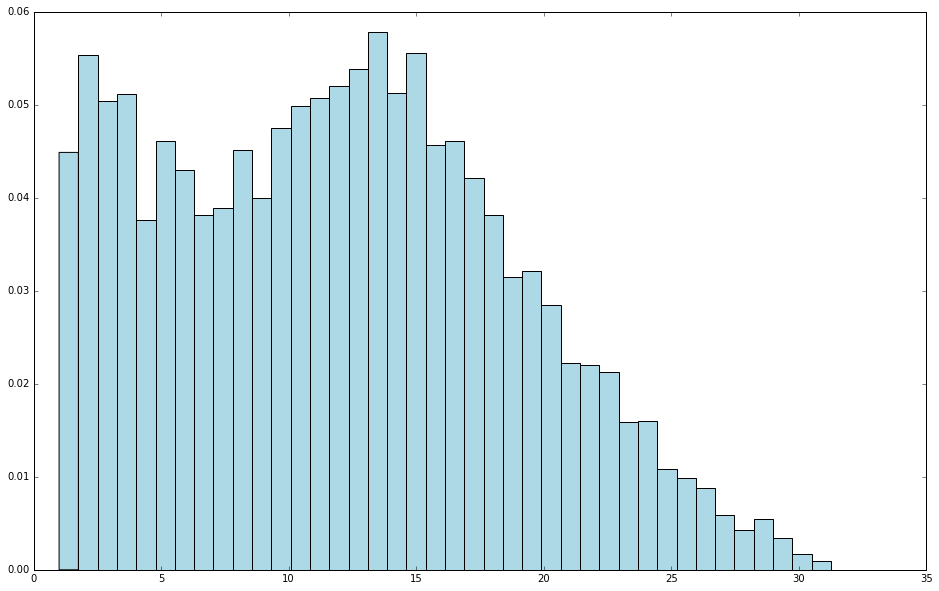

In [178]:
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()
hist(sqrt_targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [179]:
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

mse_log = true_vs_predicted_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log = true_vs_predicted_log.map(lambda (t, p): abs_error(t,p)).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda (t, p): squared_log_error(t, p)).mean())

print "Mean Squared Error: %2.4f" % mse_log
print "Mean Absoluate Error: %2.4f" % mae_log
print "Root Mean Squared Log Error: %2.4f" % rmsle_log

print "Non log-transformed predictions:\n" + str(true_vs_predicted.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3))

Mean Squared Error: 50685.5559
Mean Absoluate Error: 155.2955
Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
[(16.0, 117.89250386724844), (40.0, 116.22496123192109), (32.0, 116.02369145779232)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456198), (40.0, 26.959480191001749), (32.0, 26.654725629458007)]


In [194]:
data_with_idx = data.zipWithIndex().map(lambda (k, v): (v, k))
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test)

train_data = train.map(lambda (idx, p): p)
test_data = test.map(lambda (idx, p): p)
train_size = train_data.count()
test_size = test_data.count()
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size
print "Total data size: %d" % num_data
print "Train + Test size: %d" % (train_size + test_size)

Training data size: 13843
Test data size: 3536
Total data size: 17379
Train + Test size: 17379


In [182]:
data_with_idx_dt = data_dt.zipWithIndex().map(lambda (k, v): (v, k))
test_dt = data_with_idx_dt.sample(False, 0.2, 42)
train_dt = data_with_idx_dt.subtractByKey(test_dt)

train_data_dt = train_dt.map(lambda (idx, p): p)
test_data_dt = test_dt.map(lambda (idx, p): p)
train_size_dt = train_data_dt.count()
test_size_dt = test_data_dt.count()
print "Training data size: %d" % train_size_dt
print "Test data size: %d" % test_size_dt
print "Total data size: %d" % num_data
print "Train + Test size: %d" % (train_size_dt + test_size_dt)

Training data size: 13843
Test data size: 3536
Total data size: 17379
Train + Test size: 17379


In [183]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle

In [184]:
params = [1, 5, 10, 20, 50, 100]
metrics = [evaluate(train_data, test_data, param, 0.01, 0.0, 'l2', False) for param in params]
print params
print metrics

[1, 5, 10, 20, 50, 100]
[2.9147188878375019, 2.0623935392858921, 1.7904244862988534, 1.5859030304527442, 1.4245105292416063, 1.3793816432563457]


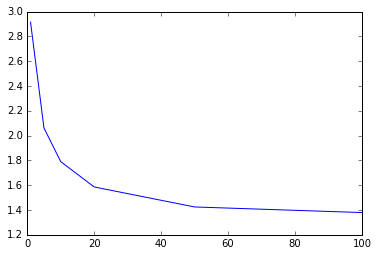

In [185]:
plot(params, metrics)
fig = matplotlib.pyplot.gcf()

In [186]:
params = [0.01, 0.025, 0.05, 0.1, 1.0]
metrics = [evaluate(train_data, test_data, 10, param, 0.0, 'l2', False) for param in params]
print params
print metrics

[0.01, 0.025, 0.05, 0.1, 1.0]
[1.7904244862988534, 1.4241062778987466, 1.3840130355866163, 1.4560061007109475, nan]


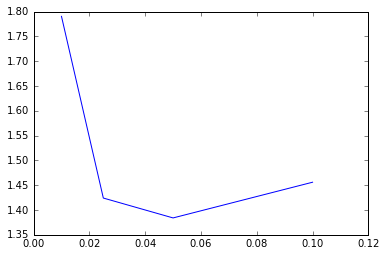

In [187]:
plot(params, metrics)
fig = matplotlib.pyplot.gcf()

[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.4560061007109475, 1.4553905791813473, 1.4499628170008274, 1.4064367998474196, 1.3918788728243279, 1.5372798797455094, 1.8443557250379143]


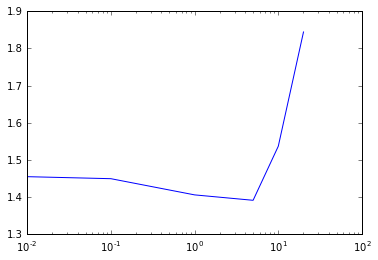

In [188]:
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2', False) for param in params]
print params
print metrics

plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4560061007109475, 1.4559726288863273, 1.455671743579271, 1.4529062846084286, 1.4276361714164854, 1.7720360206813013, 4.7975574647546564]


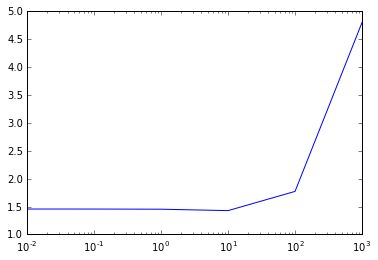

In [189]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
print params
print metrics

plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

In [190]:
model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=1.0, regType='l1', intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=10.0, regType='l1', intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=100.0, regType='l1', intercept=False)

print "L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0))
print "L1 (10.0) number of zero weights: " + str(sum(model_l1_10.weights.array == 0))
print "L1 (100.0) number of zero weights: " + str(sum(model_l1_100.weights.array == 0))

L1 (1.0) number of zero weights: 5
L1 (10.0) number of zero weights: 33
L1 (100.0) number of zero weights: 58


[False, True]
[1.4064367998474196, 1.4358305401660159]


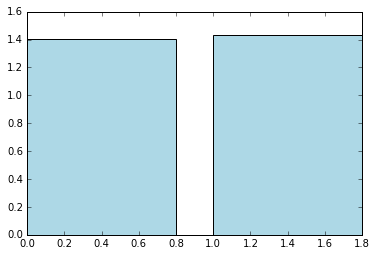

In [191]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]
print params
print metrics

bar(params, metrics, color='lightblue')
fig = matplotlib.pyplot.gcf()

In [195]:
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle

[1, 2, 3, 4, 5, 10, 20]
[1.0096683340936519, 0.91969992278272761, 0.8153844681589919, 0.73662190225082969, 0.63743991277301437, 0.41268609723707311, 0.44150092501568089]


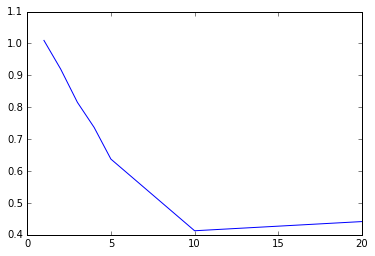

In [196]:
params = [1, 2, 3, 4, 5, 10, 20]
metrics = [evaluate_dt(train_data_dt, test_data_dt, param, 32) for param in params]
print params
print metrics

plot(params, metrics)
fig = matplotlib.pyplot.gcf()

[2, 4, 8, 16, 32, 64, 100]
[1.2571956557524344, 0.81163776220529393, 0.75846230141673943, 0.62020394014589464, 0.63743991277301437, 0.63743991277301437, 0.63743991277301437]


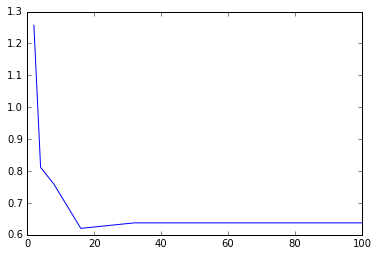

In [198]:
params = [2, 4, 8, 16, 32, 64, 100]
metrics = [evaluate_dt(train_data_dt, test_data_dt, 5, param) for param in params]
print params
print metrics

plot(params, metrics)
fig = matplotlib.pyplot.gcf()